In [50]:
import random
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
from pprint import pprint
from sklearn.cluster import KMeans  # Unsupervised ML algo
import pandas as pd
%matplotlib inline



#---------------------------- initialization
fog=200
energy_threshold=10       # minimum energy Level required to send the packet
energy_level_decreased=2  # Energy level decreased after a successfull packet delivery
total_bits=500            # Packet size in Bit
load_per_bit=10           # Unit load per Bit

In [51]:
fog_properties=[
                {"fog_node":i,
                "power_consumption":round(random.randint(5,15)+random.random(),2),
                 "load_capacity":round(random.randint(1,100)+random.random(),2),
                 "energy":round(random.randint(0,100) * random.random(),2),
                 "x_axis":round(random.randint(0,50) * random.random(),3),
                 "y_axis":round(random.randint(0,50) * random.random(),3)                 
                 }
                for i in range(fog)]  # we have create fog nodes with random properties

df = pd.DataFrame(fog_properties)
kmeans = KMeans(n_clusters=3, random_state=0)
df['cluster'] = kmeans.fit_predict(df[['x_axis', 'y_axis']])
centroids = kmeans.cluster_centers_
cen_x = [i[0] for i in centroids] 
cen_y = [i[1] for i in centroids]
df['cen_x'] = df.cluster.map({0:cen_x[0], 1:cen_x[1], 2:cen_x[2]})
df['cen_y'] = df.cluster.map({0:cen_y[0], 1:cen_y[1], 2:cen_y[2]})
colors = ['#0004ff', '#00ff40', '#a142f5']
df['clr'] = df.cluster.map({0:colors[0], 1:colors[1], 2:colors[2]})
df["c_dist"]=df.apply(lambda x: (((x.x_axis-x.cen_x)+(x.y_axis-x.cen_y))**2)**(0.5) , axis=1) # Euclidean distance
df.sort_values(by=['cluster','c_dist'],inplace=True)
df["special_node"]=df.apply(lambda x: int(df[df["cluster"]==x.cluster][:1].fog_node),axis=1)
special_nodes_df=df[df["fog_node"]==df["special_node"]]

In [52]:
df.tail(5)

,fog_node,power_consumption,load_capacity,energy,x_axis,y_axis,cluster,cen_x,cen_y,clr,c_dist,special_node
178,178,14.03,99.02,40.38,28.908,22.897,2,28.688633,6.774367,#a142f5,16.342,61
93,93,15.21,83.73,91.75,40.605,19.277,2,28.688633,6.774367,#a142f5,24.419,61
128,128,9.81,44.58,80.75,38.161,22.439,2,28.688633,6.774367,#a142f5,25.137,61
175,175,15.09,21.76,33.67,44.543,19.313,2,28.688633,6.774367,#a142f5,28.393,61
132,132,10.30,78.05,35.59,41.167,23.112,2,28.688633,6.774367,#a142f5,28.816,61


Text(0, 0.5, 'Y Axis')

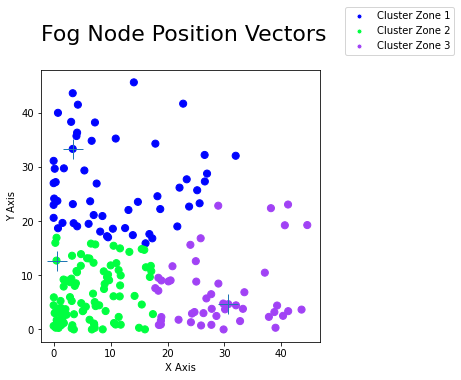

In [53]:
fig, ax = plt.subplots(1, figsize=(5,5))
plt.scatter(df.x_axis, df.y_axis, c=df.clr, alpha =1, s=50)
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Cluster Zone {}'.format(i+1), 
               markerfacecolor=mcolor, markersize=5) for i, mcolor in enumerate(colors)]
plt.legend(handles=legend_elements,bbox_to_anchor =(1.5, 1.25))
plt.title('Fog Node Position Vectors\n', loc='left', fontsize=22)
plt.plot(special_nodes_df.x_axis,special_nodes_df.y_axis, marker="+",linestyle='none',markersize=20)
plt.xlabel('X Axis')
plt.ylabel('Y Axis')

In [54]:
def find_max_load_node():
    global df
    global energy_threshold
    global energy_level_decreased
    global load_per_bit
    
    df.sort_values(by=['energy','load_capacity'],inplace=True,ascending=False)
    
    if(int(df[:1].energy)<energy_threshold):
        return False
    elif(int(df[:1].fog_node)!=int(df[:1].special_node) and int(df[:1].load_capacity)>=load_per_bit):
        fog_node=int(df[:1].fog_node)
        res={"fog_node":fog_node,
            "parent_node":int(df[:1].special_node),
            "load_capacity":float(df[:1].load_capacity),
             "energy":float(df[:1].energy),
             "x_axis":float(df[:1].x_axis),
             "y_axis":float(df[:1].y_axis),
             "p_x":float(df[df["fog_node"]==int(df[:1].special_node)][:1].x_axis),
             "p_y":float(df[df["fog_node"]==int(df[:1].special_node)][:1].y_axis),
            "total_power_consuming":float(df[:1].power_consumption)+
                float(df[df["fog_node"]==int(df[:1].special_node)][:1].power_consumption)}
        
        df.at[fog_node,'energy']=res['energy']-energy_level_decreased   # Child Node Energy minus
        #df.at[res['parent_node'],'energy']=res['energy']-energy_level_decreased # Parent Node Energy minus
        return res
        
    else:
        res=False        
        for index, row in df.iterrows():           
            if(row['energy']<energy_threshold):
                return res
            else:
                if(row['load_capacity']>=load_per_bit and int(row['fog_node'])!=int(row['special_node'])):                    
                    fog_node=int(row['fog_node'])
                    res={"fog_node":fog_node,
                        "parent_node":int(row['special_node']),
                         "energy":float(row['energy']),
                        "load_capacity":float(row['load_capacity']),
                         "x_axis":float(row['x_axis']),
                         "y_axis":float(row['y_axis']),
                         "p_x":float(df[df["fog_node"]==int(row['special_node'])][:1].x_axis),
                         "p_y":float(df[df["fog_node"]==int(row['special_node'])][:1].y_axis),
                        "total_power_consuming":float(row['power_consumption'])+
                            float(df[df["fog_node"]==int(row['special_node'])][:1].power_consumption)}
                    
                    df.at[index,'energy']=res['energy']-energy_level_decreased  # Child Node Energy minus
                    #df.at[res['parent_node'],'energy']=res['energy']-energy_level_decreased # Parent Node Energy minus
                    return res

In [55]:
time_vs_energy=[]
node_x=[]
node_y=[]
sent=[]
for i in range(total_bits):
    res=find_max_load_node()

    if(res==False):
        for j in range(total_bits-i):
            time_vs_energy.append(0)
            sent.append(0)
        break
        
    else:
        sent.append(1)
        time_vs_energy.append(res["energy"])
        
        node_x.append(res['x_axis'])
        node_y.append(res['y_axis'])
        
        node_x.append(res['p_x'])
        node_y.append(res['p_y'])

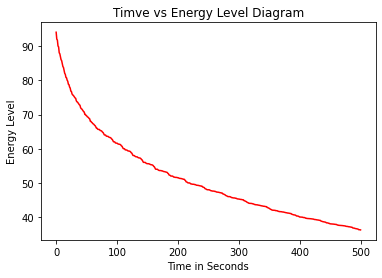

In [56]:
ypoints = np.array(time_vs_energy)
plt.plot(ypoints, linestyle = '-',color="r")
plt.xlabel("Time in Seconds")
plt.ylabel("Energy Level")
plt.title("Timve vs Energy Level Diagram")
plt.show()

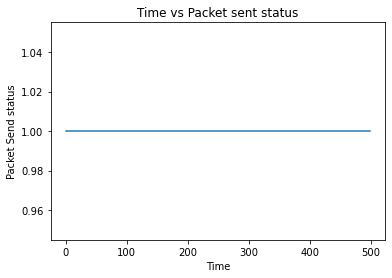

In [57]:
plt.plot(sent)
plt.xlabel("Time")  # add X-axis label
plt.ylabel("Packet Send status")  # add Y-axis label
plt.title("Time vs Packet sent status")  # add title
plt.show()

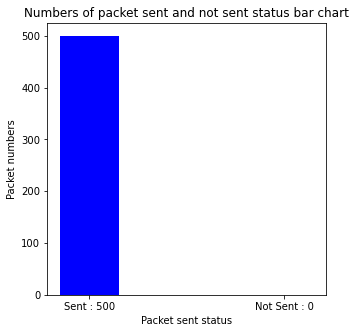

In [58]:
fig = plt.figure(figsize = (5, 5))
# creating the bar plot
plt.bar(['Sent : '+str(sent.count(1)),'Not Sent : '+str(sent.count(0))],
        [sent.count(1),sent.count(0)], color ='blue', width = 0.3)
plt.xlabel("Packet sent status")
plt.ylabel("Packet numbers")
plt.title("Numbers of packet sent and not sent status bar chart")
plt.show()